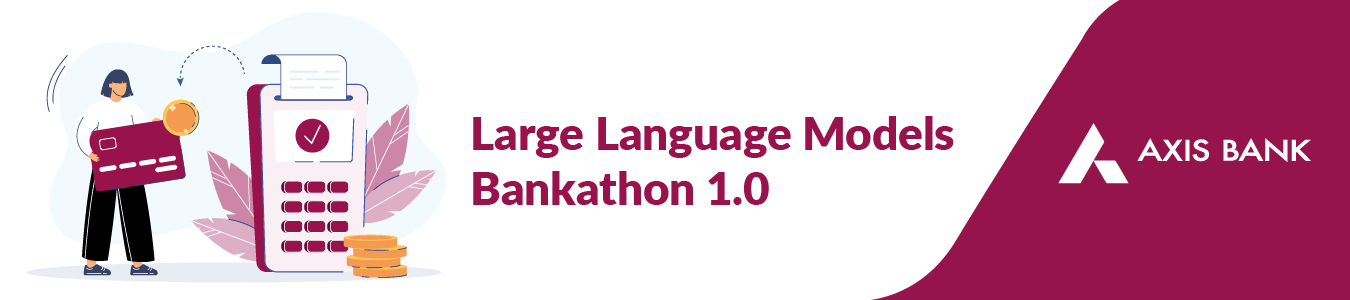

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing the Libraries**

---



In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U einops
!pip install -q -U PyPDF2
!pip install -q -U python-docx
!pip install -q -U docx2txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Importing all the libraries**

---



In [ ]:
import os
import re
import json
import PyPDF2
import docx2txt
import warnings
import bitsandbytes as bnb
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
from tabulate import tabulate
from collections import defaultdict
import spacy
from spacy.matcher import Matcher
from datasets import load_dataset
from flask import Flask, request, jsonify, render_template, session
from sklearn.metrics.pairwise import cosine_similarity
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

warnings.filterwarnings("ignore")
device = "cuda:0"

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication

**Quantizing the Llama-2 7B Parameter Model**

---



In [ ]:
MODEL_NAME = "TheBloke/Llama-2-7b-chat-fp16"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token_id = (0)
tokenizer.padding_side = 'right'

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Setting Model Config for Inference**

---



In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.3
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
def find_nth_occurrence(sentence, substring, n):
    start_index = -1

    for _ in range(n):
        start_index = sentence.find(substring, start_index + 1)
        if start_index == -1:
            break

    return start_index

##### Function to Generate Model Response

In [ ]:
def generate_response(prompt: str, pos: int) -> str:
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    response = tokenizer.decode(outputs[0],skip_special_tokens=True)

    assistant_start = '<assistant>:'
    response_start = find_nth_occurrence(response, assistant_start, pos)
    return response[response_start + len(assistant_start):].strip()



---



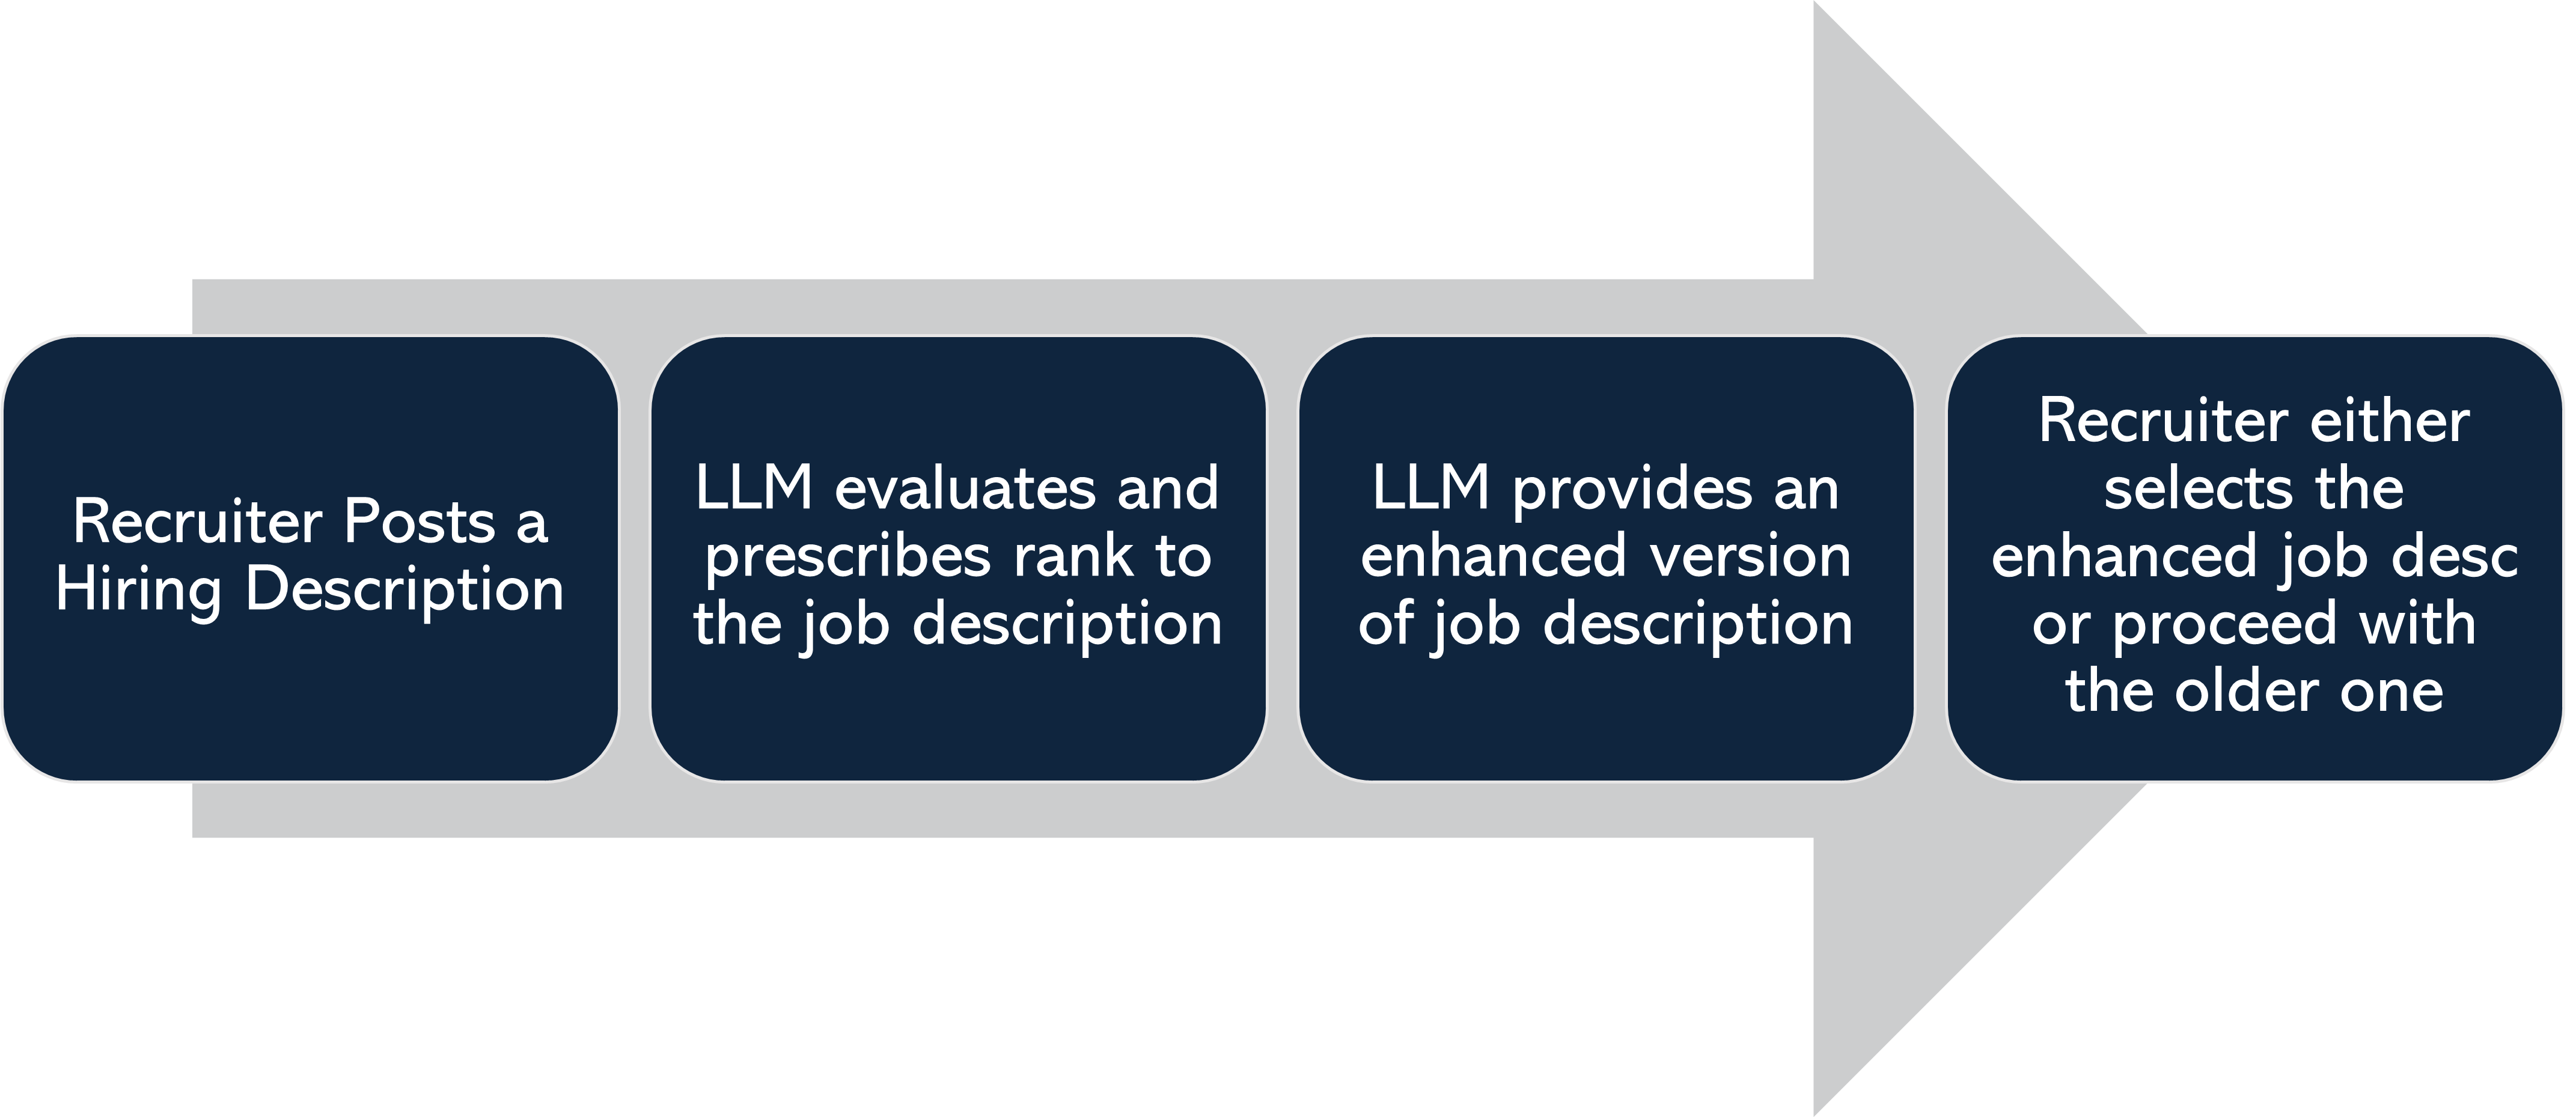

**Job Description evaluation**

*   Score the job description based on the job title, and provide recommendations for enhancements.
*   Give the user the option to either continue with the original version or incorporate the suggested changes.





In [ ]:
def path_to_file(file):
  return "/content/drive/MyDrive/Bankathon/" + file

In [ ]:
with open(path_to_file('job desc.json'), 'r') as json_file:
    data = json.load(json_file)

In [ ]:
job_desc = data['job_desc']
job_title = data['job_title']

##### Function to Create Prompt for Job Description Evaluation

In [ ]:
def generate_job_desc(instruct, job_title, job_desc):
  prompt = f"""
### <instruction>: {instruct}
### <human>: Job Title : {job_title}
             Job description : {job_desc}
### <assistant>:
  """.strip()
  return prompt

In [ ]:
instruct_rank = '''based on the job title rank the job description written and suggest if any enhancement is required in the description to more clearly articulate the requirement of the job. write the complete enhanced version based on the suggestions.
strictly follow the below example as template.
for example -
The rank for job description is 8/10.

Here are some suggestions to improve the job description -
1. In the job title, instead of using "Brand Manager" use "Sales Manager"
2. In the documentation and knowledge sharing section, consider adding more details on the types of documentation and knowledge sharing activities
3. ....
4. ....

The enhanced version of job description is -

Responsibilities:

Understanding of credit risk scorecards and metrics to evaluate the impact of a lending portfolio.
Understands the concept of reject inferencing, indeterminate, and sampling techniques.
Decent knowledge of implementing production grade models.
Understanding of model monitoring activity for credit risk models.
Knowledge of training models on AWS servers, such as Amazon Sagemaker.s

The Ideal Candidate:

Knowledge of implementing tree based (CART) machine learning algorithms, such as decision trees, random forest, bagging and boosting ensemble models: XGBoost, CatBoost, LightGBM, etc.
Good understanding of hyper-parameter tuning and evaluation metrics for machine learning algorithms.
Good knowledge of SQL & Python languages for data extraction and model building.
Good communication skills to collaborate with business stakeholders on understanding the requirement and feature engineering for the model training.
Good analytical and problem solving skills to manage expectations with business stakeholders in terms of business impact of the model.
'''

In [ ]:
prompt_job_desc = generate_job_desc(instruct_rank, job_title, job_desc)

**Suggestions Provided by LLaMa Model**

---







In [ ]:
job_desc = generate_response(prompt_job_desc, 1)
print(job_desc)

Based on the job description provided, I would rank the job description as 9/10.
The job description provides a clear and detailed overview of the role and responsibilities of the Data Scientist position at IBM. It covers various aspects of the job, including the job title, role and responsibilities, day-to-day duties, industry trends and innovation, and the ideal candidate.
The only improvement I would suggest is to provide more details on the specific technologies and tools the Data Scientist will be working with, such as programming languages, machine learning frameworks, and data visualization tools. This will give a clearer picture of the technical requirements of the job and help potential candidates better understand if they are a good fit for the position.
Here is an enhanced version of the job description based on the suggestions:
Job Title: Data Scientist
Role and Responsibilities:
As a Data Scientist at IBM, you will leverage your knowledge and expertise in AI and machine le

In [ ]:
def extract_rank(job_desc):
  rank = None

  # Use regex pattern to find a potential email address
  pattern = r'\b\d+\b'
  match = re.search(pattern, job_desc)
  if match:
    rank = match.group()

  return rank

**Rank Given to the Current Job Description**

---

In [ ]:
rank = extract_rank(job_desc)
if rank:
  print("Rank for the Job description ( Out of 10 ) :", rank)
else:
  print("Rank not found")

Rank for the Job description ( Out of 10 ) : 9


**Enhanced Version of Job Description**

---


In [ ]:
lines = job_desc.split('\n')

enhanced_line_index = None
for idx, line in enumerate(lines):
    if 'enhanced version' in line.lower():
        enhanced_line_index = idx
        break

extracted_text = '\n'.join(lines[enhanced_line_index + 1:])

print(extracted_text)

Job Title: Data Scientist
Role and Responsibilities:
As a Data Scientist at IBM, you will leverage your knowledge and expertise in AI and machine learning to develop and implement data-driven solutions that meet the needs of our clients. Your primary responsibilities will include:
* Developing and implementing AI and machine learning models to solve complex business problems.
* Collaborating with cross-functional teams to gather requirements, design solutions, and deploy models.
* Creating and maintaining technical documentation and knowledge sharing materials to support the adoption of AI and machine learning solutions.
* Staying up to date with the latest trends and advancements in AI, foundation models, and large language models to identify opportunities for innovation and improvement.
* Evaluating emerging technologies, tools, and frameworks to assess their potential impact on solution design and implementation.

Ideal Candidate:

* Strong programming skills in languages such as Py



---



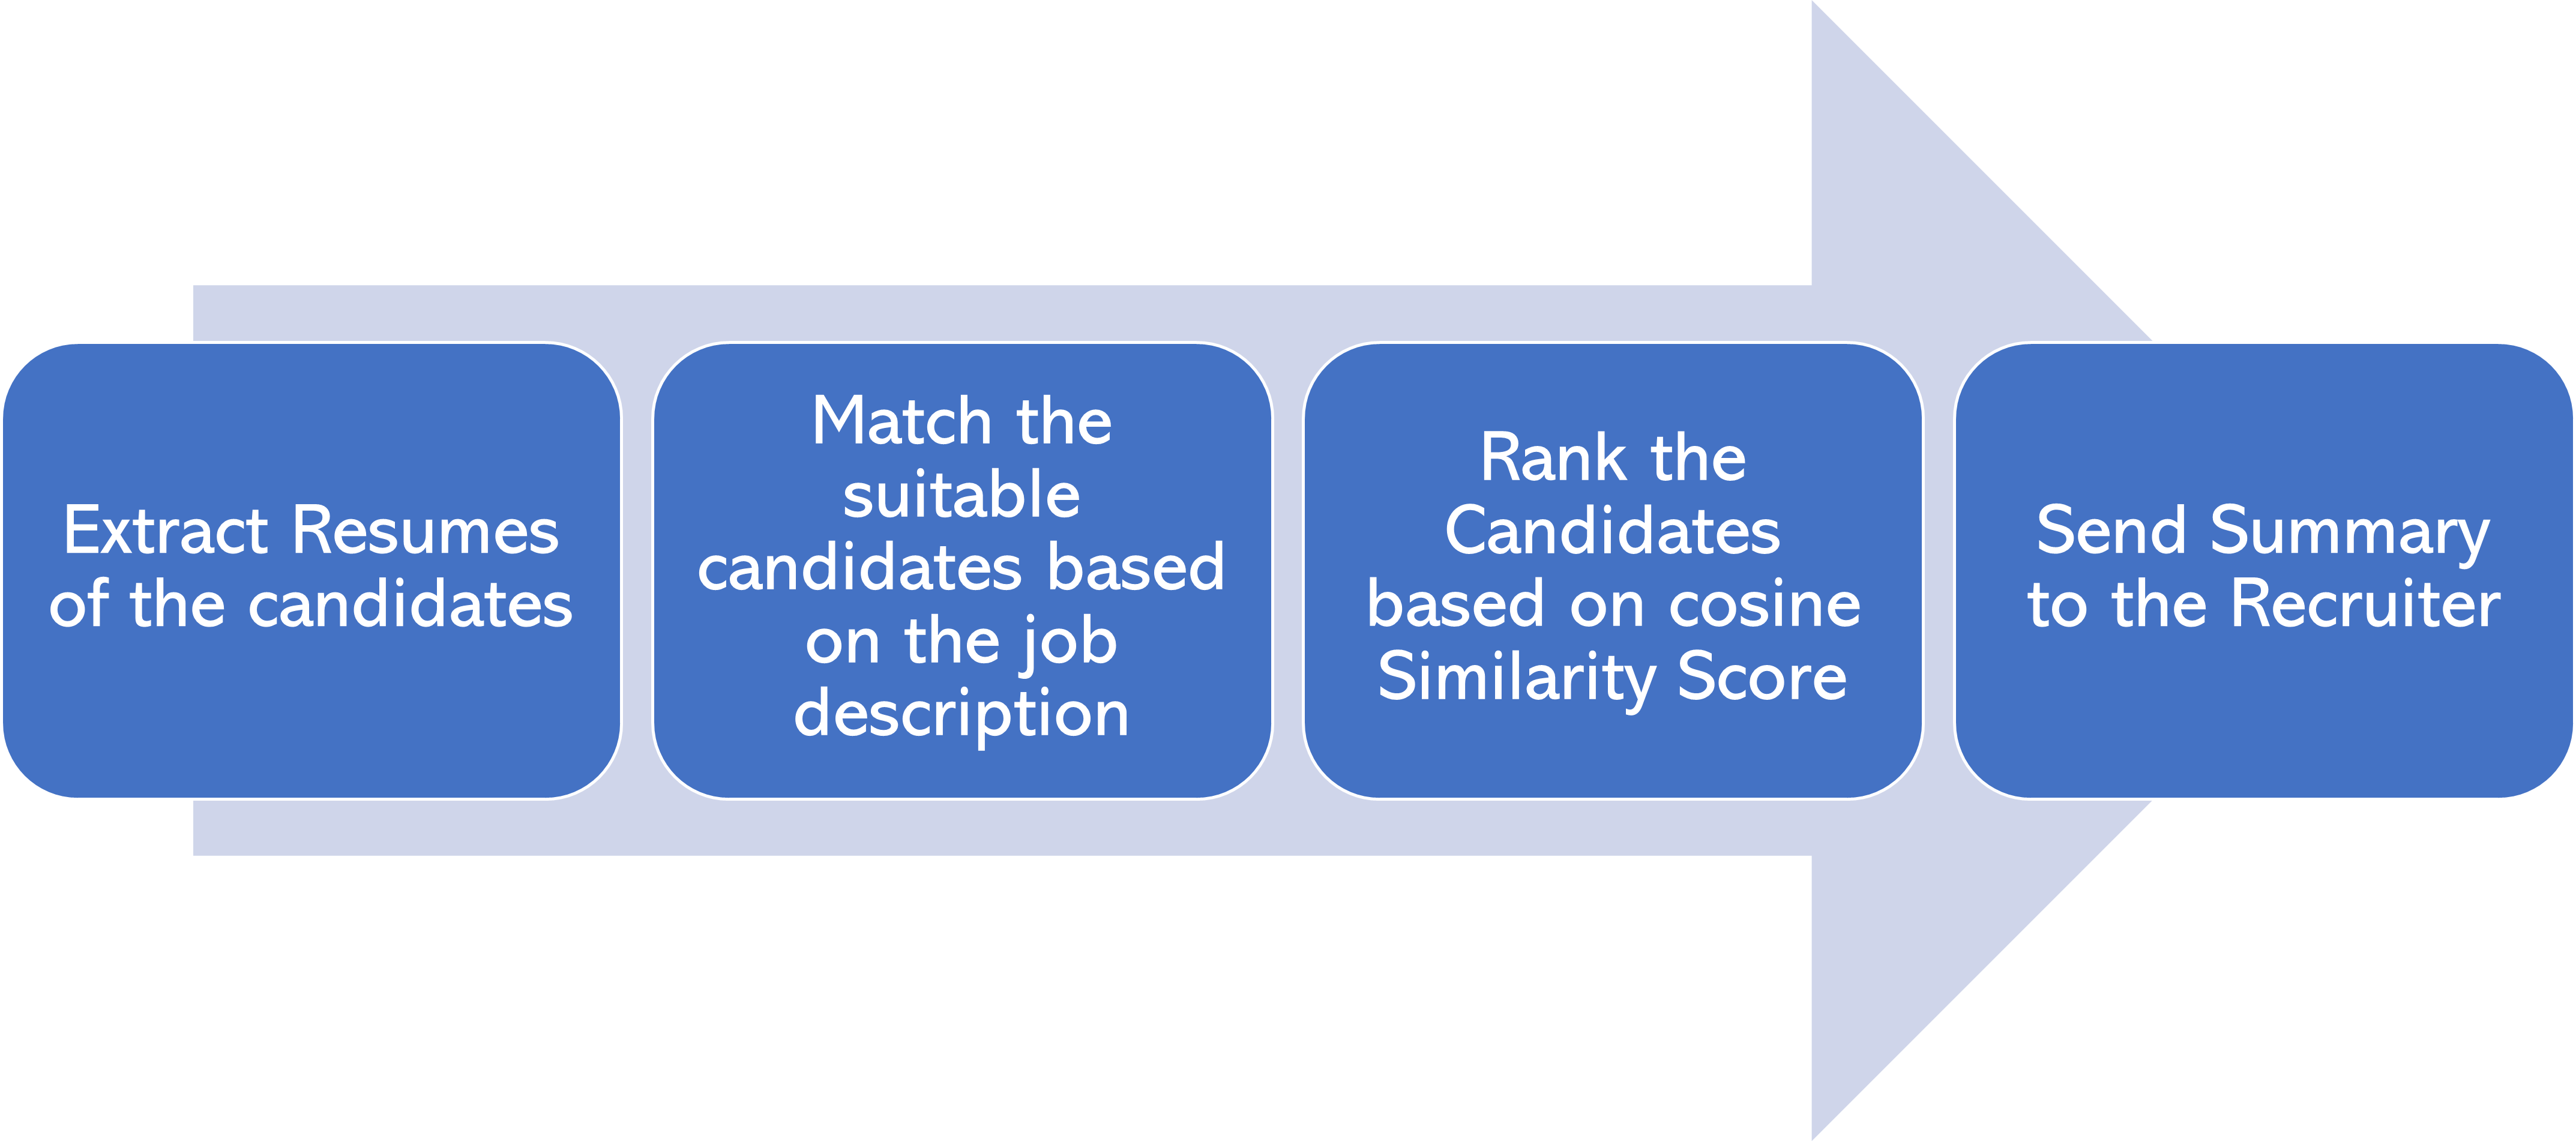

**CV ranking**
* Send emails to the shortlisted candidates, informing them about the next steps in the hiring process.
*   Rank the CVs according to their alignment with the job requirements and shortlist candidates.
*   Provide additional information on the shortlisted candidates.

**Email notifications**
* Send emails to the shortlisted candidates, informing them about the next steps in the hiring process


In [ ]:
job_req = tokenizer(extracted_text, padding = 'max_length', truncation = True, max_length = 4096)

In [ ]:
job_req = np.array(job_req.input_ids)

**Extract all the resumes**

---



In [ ]:
def read_pdf(path):
  pdf_file_path = path
  pdf_file = open(pdf_file_path, 'rb')

  pdf_reader = PyPDF2.PdfReader(pdf_file)

  num_pages = len(pdf_reader.pages)

  page_text = ""
  for page_num in range(num_pages):
      page = pdf_reader.pages[page_num]
      page_text += page.extract_text()

  pdf_file.close()
  return page_text

In [ ]:
def read_word(path):
  page_text = docx2txt.process(path)
  return page_text

In [ ]:
def extract_email(text):
    email = None

    pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
    match = re.search(pattern, text)
    if match:
        email = match.group()

    return email

In [ ]:
def extract_name(resume_text):
    nlp = spacy.load('en_core_web_sm')
    matcher = Matcher(nlp.vocab)

    patterns = [
        [{'POS': 'PROPN'}, {'POS': 'PROPN'}],  # First name and Last name
        [{'POS': 'PROPN'}, {'POS': 'PROPN'}, {'POS': 'PROPN'}],  # First name, Middle name, and Last name
        [{'POS': 'PROPN'}, {'POS': 'PROPN'}, {'POS': 'PROPN'}, {'POS': 'PROPN'}]  # First name, Middle name, Middle name, and Last name

    ]

    for pattern in patterns:
        matcher.add('NAME', patterns=[pattern])

    doc = nlp(resume_text)
    matches = matcher(doc)

    for match_id, start, end in matches:
        span = doc[start:end]
        return span.text

    return None

##### Function to Create Prompt to Evaluate Resumes of Candidates

In [ ]:
def generate_skills(instruct, question):
  prompt = f"""
  ### <instruction>: {instruct}
  ### <human>: {question}
  ### <assistant>:
  """.strip()
  return prompt

In [ ]:
def generate_name(instruct, question):
    prompt = f"""
    ### <instruction>: {instruct}
    ### <human>: {question}
    ### <assistant>:
    """.strip()
    return prompt

In [ ]:
instruct_name = "given the resume extract the name of the employee from it"

In [ ]:
instruct_jobdesc = 'given resume of the employee extract job title, both soft and technical skills, experience in all the different positions and what they have implemented in those positions'

In [ ]:
directory_path = '/content/drive/MyDrive/Bankathon/Resume/'

In [ ]:
file_list = os.listdir(directory_path)

In [ ]:
dict_table = defaultdict(list)

In [ ]:
for resumes in file_list:
    file_path = os.path.join(directory_path, resumes)
    if resumes.lower().endswith('.pdf'):
      page_text = read_pdf(file_path)
    else:
      page_text = read_word(file_path)

    prompt_name = generate_name(instruct_name, page_text)
    fname = generate_response(prompt_name, 1)

    name = extract_name(fname)
    email = extract_email(page_text)

    prompt = generate_skills(instruct_jobdesc, page_text)
    exp = generate_response(prompt, 1)

    details = tokenizer(exp, padding = 'max_length', truncation = True, max_length = 4096)
    details = np.array(details.input_ids)

    val = cosine_similarity(details.reshape(1, -1), job_req.reshape(1, -1))[0][0]

    dict_table['Name'].append(name)
    dict_table['Email ID'].append(email)

    if val > 0.25:
      dict_table['Result'].append('Selected')
    else:
      dict_table['Result'].append('Not Selected')

**List of Selected and Non-Selected Based on their Resume Details**

---



In [ ]:
print(tabulate(dict_table, headers='keys', tablefmt='grid'))

+---------------+--------------------------------+--------------+
| Name          | Email ID                       | Result       |
+===============+================================+==============+
| HOWARD ONG    | hello@reallygreatsite.com      | Selected     |
+---------------+--------------------------------+--------------+
| CÉSAR CABAL   | ccabal43@email.com             | Not Selected |
+---------------+--------------------------------+--------------+
| Aditya Singh  | aditya070298@gmail.com         | Selected     |
+---------------+--------------------------------+--------------+
| Anirudh Kumar | Cristiano.expedition@gmail.com | Not Selected |
+---------------+--------------------------------+--------------+
| Donna Robbins | donna@example.com              | Not Selected |
+---------------+--------------------------------+--------------+


**Sending Mail to Selected Candidates**

---



In [ ]:
def create_email(name, job_title):
  message = f'''Dear {name},

We are delighted to inform you that we have considered your profile for {job_title} role.
Details realated to the next round will be communicated soon.

Regards,
HR Axis Bank'''
  return message

##### Function to Send Email to Selected Candidates

In [ ]:
def send_email(name, email, job_title):
  smtp_server = 'smtp.example.com'
  smtp_port = 587
  sender_email = 'cristiano.expedition@gmail.com'
  sender_password = '$$$$$'
  recipient_email = email

  subject = f'Profile selected for an {job_title} position'
  message = create_email(name, job_title)

  msg = MIMEMultipart()
  msg['From'] = sender_email
  msg['To'] = recipient_email
  msg['Subject'] = subject
  msg.attach(MIMEText(message, 'plain'))

  # Establish the SMTP connection
  try:
      smtp_server = smtplib.SMTP('smtp.gmail.com', 587)
      smtp_server.starttls()
      smtp_server.login(sender_email, sender_password)

      # Send the email
      smtp_server.sendmail(sender_email, recipient_email, msg.as_string())

      print("Email sent successfully!")
  except Exception as e:
      print("An error occurred:", str(e))
  finally:
      smtp_server.quit()

In [ ]:
for index in range(len(dict_table['Name'])):
  if dict_table['Result'][index] == 'Selected':
    send_email(dict_table['Name'][index], dict_table['Email ID'][index], job_title)

Email sent successfully!
Email sent successfully!


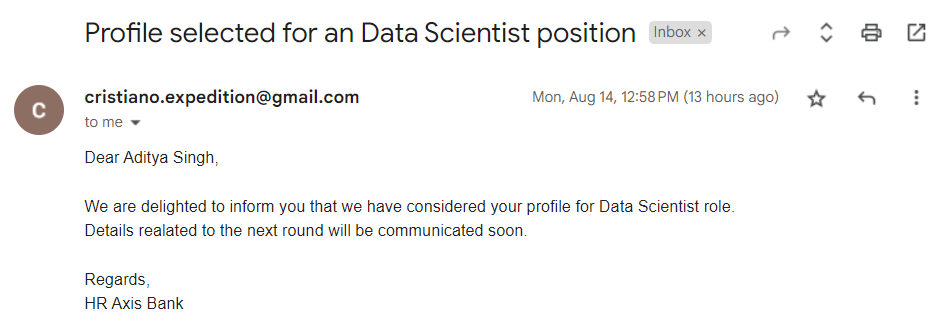



---



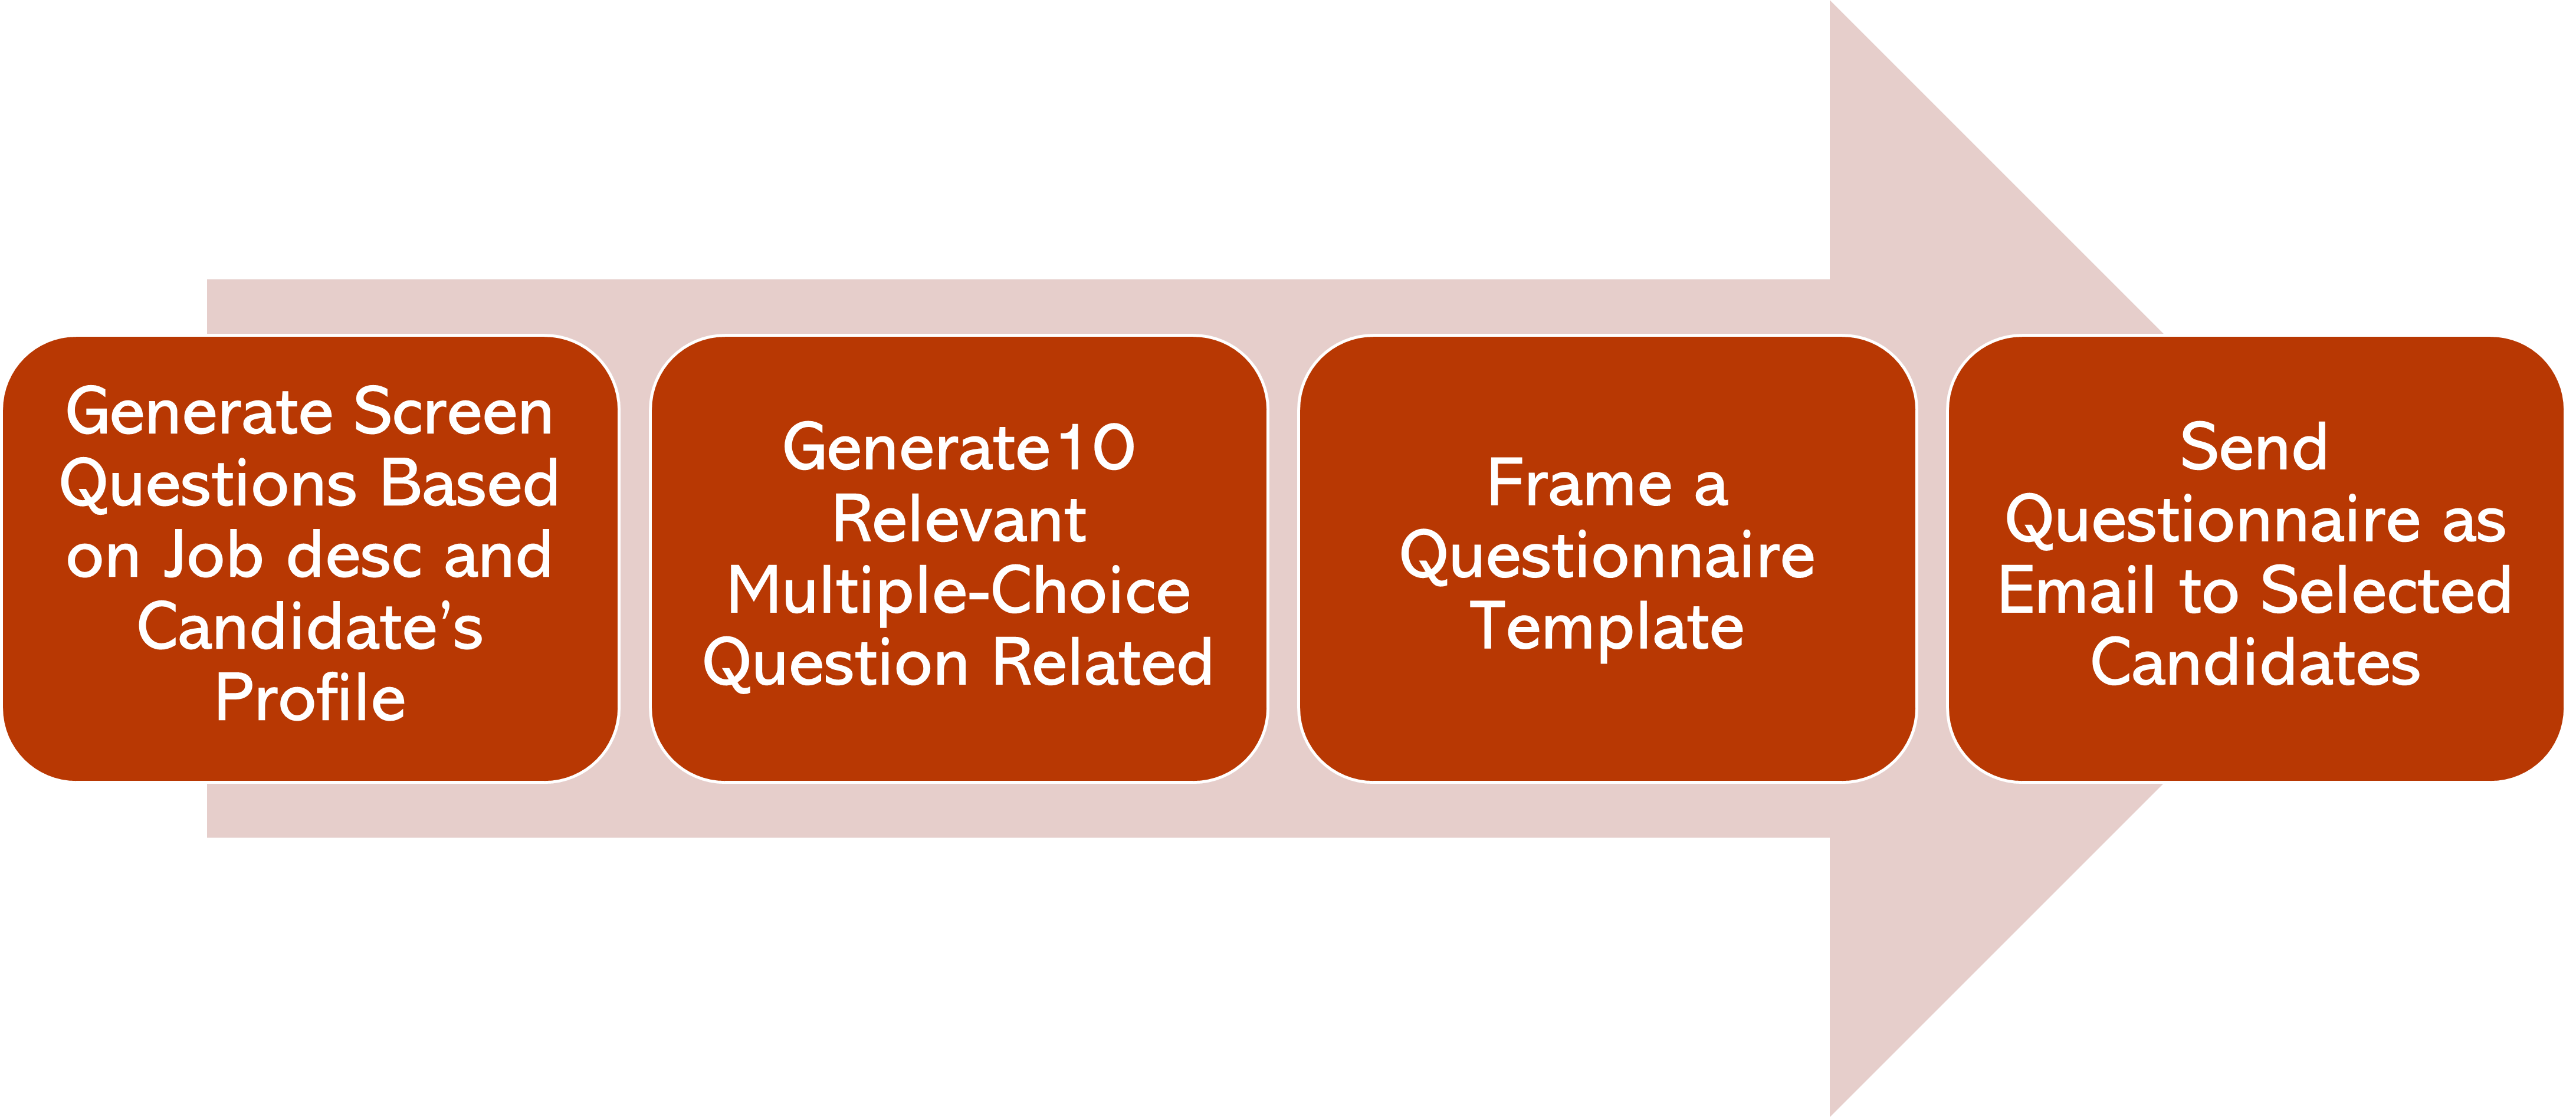

**Screening questions**

*   Develop screening questions for each candidate, considering different levels of importance or significance assigned to the job description and the candidate's CV




In [ ]:
path = '/content/drive/MyDrive/Bankathon/Resume/Aditya_Singh_Resume.pdf'

In [ ]:
resume_text = read_pdf(path)

In [ ]:
job_prompt = generate_skills(instruct_jobdesc, resume_text)
job_exp = generate_response(job_prompt, 1)

In [ ]:
instruct_ques = '''Based on the job description and candidate's skill and experience prepare 10 subject based multiple choice questions for the candidate's interview. So candidate's theoritical knowledge can be evaluated. All the questions should have multiple choices.

strictly follow below example as template for screening questions.

example -

1. The Accounting Rate of Return is also Known as?
   a.) Return on debt
   b.) Return on Capital
   c.) Return on equity
   d.) Interest

2. In the share market, the market value of any share is decided by?
   a.) shareholders
   b.) the government
   c.) investment market
   d.) respective companies
'''

##### Function to Create Prompt to Develop Screening Questions

In [ ]:
def generate_questions(instruct, job_desc, skills):
    prompt = f"""
### <instruction>: {instruct}
### <human>: Job Description : \n {job_desc}  \n\n  Candidate's Skill : \n {skills}
### <assistant>:
    """.strip()
    return prompt

In [ ]:
prompt_ques = generate_questions(instruct_ques, extracted_text, job_exp)

In [ ]:
ques = generate_response(prompt_ques, 1)

**Question Generated by the LLM Based on Job Description and Candidate's Skill**

---



In [ ]:
pattern = re.compile(r"(\d+\..+?)(?=(\d+\.|\Z))", re.DOTALL)
matches = pattern.findall(ques)
mcq = []

questions_and_options = [match[0].strip() for match in matches]

for i, question in enumerate(questions_and_options):
    mcq.append(question)
    print(f"{question}")
    print()

1. What is the difference between a Naive Bayes classifier and a Decision Tree classifier?
a.) The former is more accurate, while the latter is faster.
b.) The former is faster, while the latter is more accurate.
c.) They are the same, but the former is more popular.
d.) They are different, but both are used for classification.

2. What is the purpose of regularization in machine learning?
a.) To prevent overfitting
b.) To improve model interpretability
c.) To reduce the complexity of the model
d.) To increase the accuracy of the model

3. What is the difference between a convolutional neural network (CNN) and a recurrent neural network (RNN)?
a.) The former is used for image processing, while the latter is used for time series data.
b.) The former is used for time series data, while the latter is used for image processing.
c.) The former is more complex, while the latter is simpler.
d.) The former is simpler, while the latter is more complex.

4. What is the difference between a linea



---



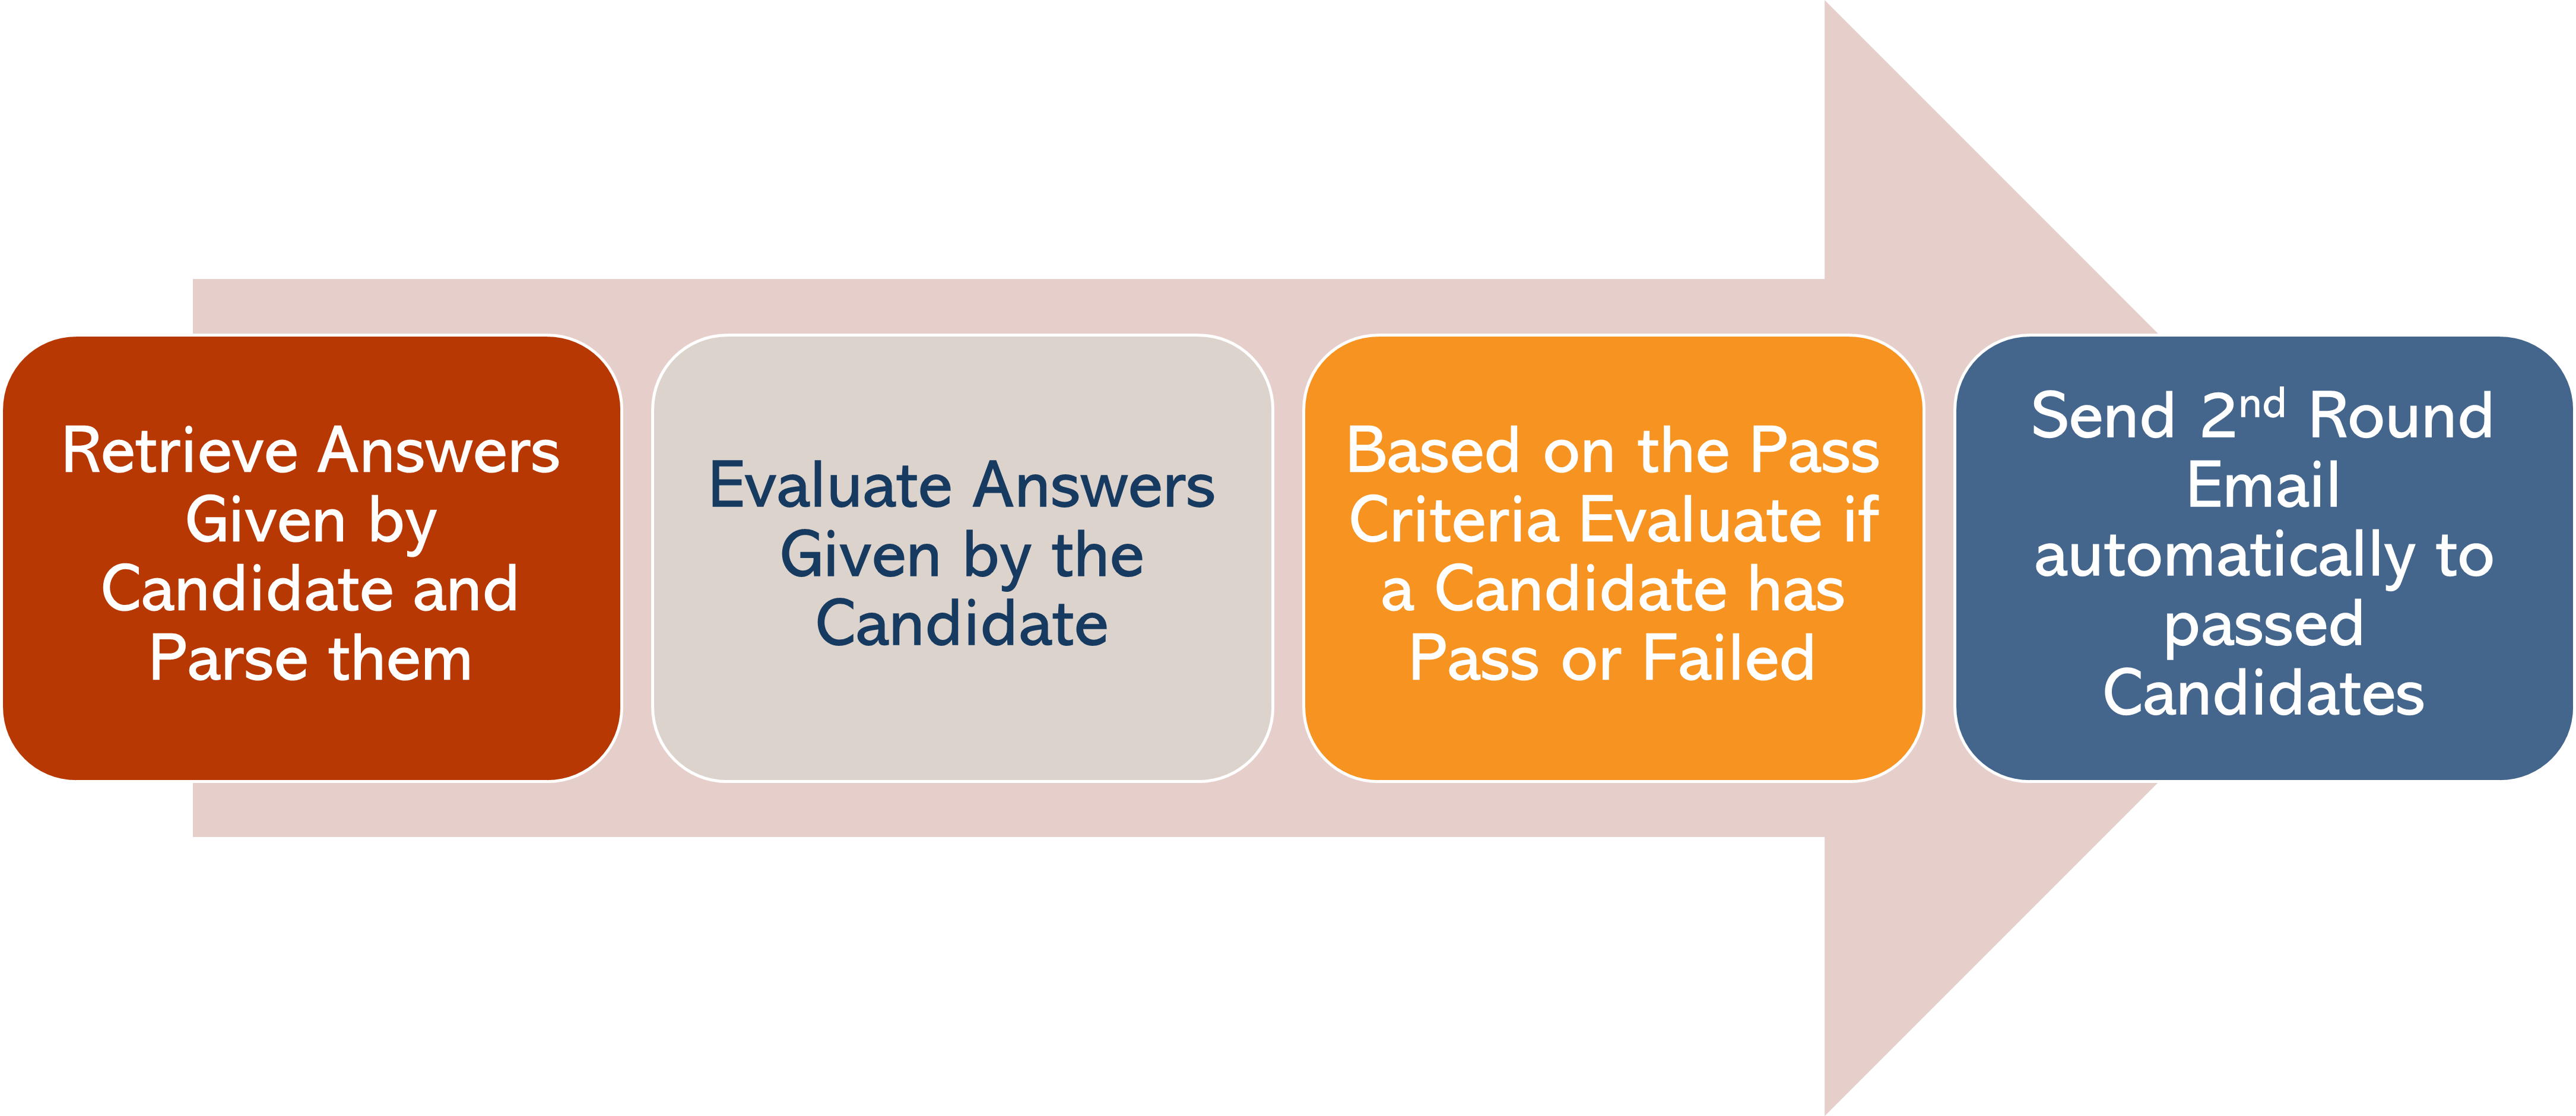

**First-round interview**

*   Conduct the first-round of interview.
*   Record the candidate's responses to the screening questions.
*   Evaluate their performance for consideration in the next in-person round.



In [ ]:
with open(path_to_file('answers.json'), 'r') as json_file:
    data = json.load(json_file)

In [ ]:
instruct_score = '''Based on the answer given for the multiple choice questions evaluate candidate's answers and give a detailed explanation of which answer is correct and which one is wrong.
strictly follow the below example as template for evaluation
example -
1. For question 1, the correct answer is (b) the former is more accurate, while the latter is faster
2. For question 2, the correct answer is (d) To improve model interpretability
3. For question 3, the correct answer is (a) The former is used for image processing, while the latter is used for time series data.
4'''

##### Function to Create Prompt to Evaluate Candidate's Answers

In [ ]:
def cal_score(instruct, questions):
    prompt = f"""
### <instruction>: {instruct}
### <human>: {questions}
### <assistant>:
    """.strip()
    return prompt

In [ ]:
answer_list = data['answers']

In [ ]:
ques_ans = ""
for i in range(len(answer_list)):
  ques_ans += mcq[i] + '\n\n' + 'Answer:' + ' ' + answer_list[i] + '\n\n'

In [ ]:
print(ques_ans)

1. What is the difference between a Naive Bayes classifier and a Decision Tree classifier?
a.) The former is more accurate, while the latter is faster.
b.) The former is faster, while the latter is more accurate.
c.) They are the same, but the former is more popular.
d.) They are different, but both are used for classification.

Answer: the former is more accurate, while the latter is faster

2. What is the purpose of regularization in machine learning?
a.) To prevent overfitting
b.) To improve model interpretability
c.) To reduce the complexity of the model
d.) To increase the accuracy of the model

Answer: to improve model performance

3. What is the difference between a convolutional neural network (CNN) and a recurrent neural network (RNN)?
a.) The former is used for image processing, while the latter is used for time series data.
b.) The former is used for time series data, while the latter is used for image processing.
c.) The former is more complex, while the latter is simpler.


##### Evaluating the Answers Given by the Candidate

In [ ]:
prompt_eval = cal_score(instruct_score, ques_ans)

In [ ]:
score = generate_response(prompt_eval, 1)

In [ ]:
pattern = r'\([a-d]\)\s+(.*?)\n'
sentences = re.findall(pattern, score, re.DOTALL)

In [ ]:
res = 0
for i in range(len(answer_list)):
  if str(sentences[i].strip().lower()).find(str(answer_list[i].strip().lower())) != -1:
    res += 1

In [ ]:
prompt_name = generate_name(instruct_name, resume_text)
fname = generate_response(prompt_name, 1)
name = extract_name(fname)
email = extract_email(resume_text)

**Sending Mail to the Selected Candidate**

---



In [ ]:
print(f"The Candidate's Score is {int((res/10) * 100)} %")

The Candidate's Score is 80 %


In [ ]:
pass_num = 6
if res >= pass_num:
  print("Candidate is Selected for next round")
  send_email(name, email, job_title)

Candidate is Selected for next round
Email sent successfully!


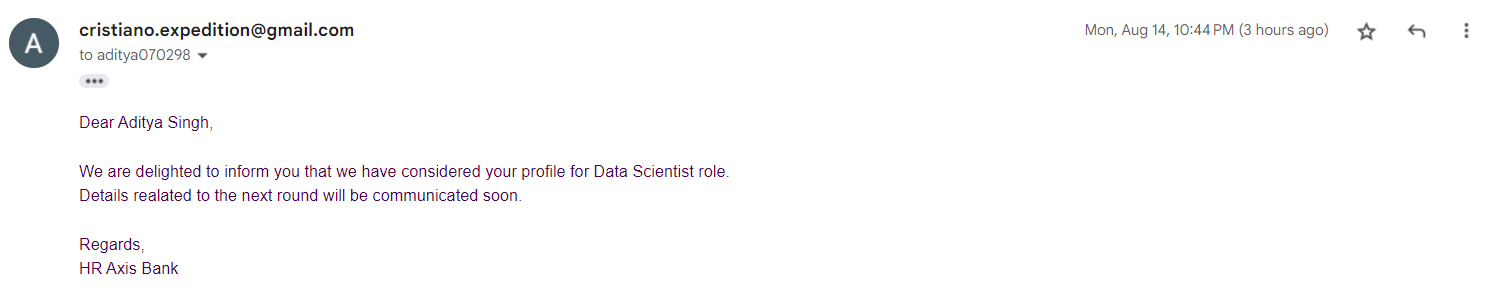